In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
#import seaborn as sn
import tensorflow as tf
import tensorflow_addons as tfa

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit
#from leven import levenshtein

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import time
import json


# TQDM Progress Bar With Pandas Apply Function
tqdm.pandas()

print(f'Tensorflow Version {tf.__version__}')
print(f'Python Version: {sys.version}')

Tensorflow Version 2.13.0
Python Version: 3.11.3 (main, Jun  5 2023, 09:32:32) [GCC 13.1.1 20230429]


# Character 2 Ordinal Encoding

In [5]:
# Read Character to Ordinal Encoding Mapping
with open('../data/character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)
    
# Ordinal to Character Mapping
ORD2CHAR = {j:i for i,j in CHAR2ORD.items()}
    
# Character to Ordinal Encoding Mapping   
display(pd.Series(CHAR2ORD).to_frame('Ordinal Encoding'))

,Ordinal Encoding
,0
!,1
#,2
$,3
%,4
&,5
',6
(,7
),8
*,9


# Global Config

In [6]:
# If Notebook Is Run By Committing or In Interactive Mode For Development
IS_INTERACTIVE = 1 # os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
# Verbose Setting during training
VERBOSE = 1 if IS_INTERACTIVE else 2
# Global Random Seed
SEED = 42
# Number of Frames to resize recording to
N_TARGET_FRAMES = 256
# Global debug flag, takes subset of train
DEBUG = False
# Number of Unique Characters To Predict + Pad Token + SOS Token + EOS Token
N_UNIQUE_CHARACTERS0 = len(CHAR2ORD)
N_UNIQUE_CHARACTERS = len(CHAR2ORD) + 1 + 1 + 1
PAD_TOKEN = len(CHAR2ORD) # Padding
SOS_TOKEN = len(CHAR2ORD) + 1 # Start Of Sentence
EOS_TOKEN = len(CHAR2ORD) + 2 # End Of Sentence
# Whether to use 10% of data for validation
USE_VAL = True
# Batch Size
BATCH_SIZE = 64
# Number of Epochs to Train for
N_EPOCHS = 2 if IS_INTERACTIVE else 100
# Number of Warmup Epochs in Learning Rate Scheduler
N_WARMUP_EPOCHS = 0 if IS_INTERACTIVE else 10
# Maximum Learning Rate
LR_MAX = 1e-3
# Weight Decay Ratio as Ratio of Learning Rate
WD_RATIO = 0.05
# Length of Phrase + EOS Token
MAX_PHRASE_LENGTH = 31 + 1
# Whether to Train The model
TRAIN_MODEL = True
# Whether to Load Pretrained Weights
LOAD_WEIGHTS = False
# Learning Rate Warmup Method [log,exp]
WARMUP_METHOD = 'exp'

# Plot Config

In [7]:
# MatplotLib Global Settings
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24

# Train

In [5]:
# Read Train DataFrame
if DEBUG:
    train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv').head(5000)
else:
    train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')
    
# Set Train Indexed By sqeuence_id
train_sequence_id = train.set_index('sequence_id')

# Number Of Train Samples
N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

display(train.info())
display(train.head())

N_SAMPLES: 67208
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67208 entries, 0 to 67207
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            67208 non-null  object
 1   file_id         67208 non-null  int64 
 2   sequence_id     67208 non-null  int64 
 3   participant_id  67208 non-null  int64 
 4   phrase          67208 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.6+ MB


None

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


# File Path

In [6]:
# Get complete file path to file
def get_file_path(path):
    return f'/kaggle/input/asl-fingerspelling/{path}'

train['file_path'] = train['path'].apply(get_file_path)

# Example File Paths

In [7]:
# Unique Parquet Files
INFERENCE_FILE_PATHS = pd.Series(
        glob.glob('/kaggle/input/aslfr-preprocessing-dataset/train_landmark_subsets/*')
    )

print(f'Found {len(INFERENCE_FILE_PATHS)} Inference Pickle Files')

Found 10 Inference Pickle Files


# Load X/y

In [8]:
X_train = np.load("/kaggle/input/aslfr-preprocessed-256/X.npy")
y_train = np.load("/kaggle/input/aslfr-preprocessing-dataset/y.npy")[:,:MAX_PHRASE_LENGTH]

if USE_VAL:
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

N_TRAIN_SAMPLES = len(X_train)
if USE_VAL:
    N_VAL_SAMPLES = len(X_val)

In [8]:
# # Train/Validation
# if USE_VAL:
#     # TRAIN
#     X_train = np.load('/kaggle/input/aslfr-preprocessing-dataset/X_train.npy')
#     y_train = np.load('/kaggle/input/aslfr-preprocessing-dataset/y_train.npy')[:,:MAX_PHRASE_LENGTH]
#     N_TRAIN_SAMPLES = len(X_train)
#     # VAL
#     X_val = np.load('/kaggle/input/aslfr-preprocessing-dataset/X_val.npy')
#     y_val = np.load('/kaggle/input/aslfr-preprocessing-dataset/y_val.npy')[:,:MAX_PHRASE_LENGTH]
#     N_VAL_SAMPLES = len(X_val)
#     # Shapes
#     print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
# # Train On All Data
# else:
#     # TRAIN
#     X_train = np.load('/kaggle/input/aslfr-preprocessing-dataset/X.npy')
#     y_train = np.load('/kaggle/input/aslfr-preprocessing-dataset/y.npy')[:,:MAX_PHRASE_LENGTH]
#     N_TRAIN_SAMPLES = len(X_train)
#     print(f'X_train shape: {X_train.shape}')

X_train shape: (54719, 128, 164), X_val shape: (7236, 128, 164)


# Example Batch

In [12]:
# Example Batch For Debugging
N_EXAMPLE_BATCH_SAMPLES = 1024
N_EXAMPLE_BATCH_SAMPLES_SMALL = 32
# Example Batch
X_batch = {
    'frames': np.copy(X_train[:N_EXAMPLE_BATCH_SAMPLES]),
    'phrase': np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES]),
#     'phrase_type': np.copy(y_phrase_type_train[:N_EXAMPLE_BATCH_SAMPLES]),
}
y_batch = np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES])
# Small Example Batch
X_batch_small = {
    'frames': np.copy(X_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
    'phrase': np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
#     'phrase_type': np.copy(y_phrase_type_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
}
y_batch_small = np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL])

# Example Parquet

In [13]:
# Read First Parquet File
# example_parquet_df = pd.read_parquet(train['file_path'][0])
example_parquet_df = pd.read_parquet(INFERENCE_FILE_PATHS[0])

# Each parquet file contains 1000 recordings
print(f'# Unique Recording: {example_parquet_df.index.nunique()}')
# Display DataFrame layout
display(example_parquet_df.head())

# Unique Recording: 1000


,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,x_left_hand_9,...,y_face_314,y_face_317,y_face_318,y_face_321,y_face_324,y_face_375,y_face_402,y_face_405,y_face_409,y_face_415
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.551424,0.538415,0.539000,0.546458,0.539715,0.543958,0.538425,0.549351,0.538230,0.540015
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550706,0.538216,0.538723,0.545990,0.539296,0.543357,0.538225,0.548827,0.537376,0.539256
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550613,0.537836,0.538564,0.545949,0.539212,0.543279,0.537961,0.548796,0.537360,0.539332
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.549740,0.536994,0.538449,0.545622,0.539666,0.543694,0.537328,0.548015,0.538301,0.539954
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550614,0.538677,0.540376,0.547104,0.541524,0.545222,0.539203,0.549211,0.539734,0.541707


# Landmark Indices

In [14]:
# Get indices in original dataframe
def get_idxs(df, words_pos, words_neg=[], ret_names=True, idxs_pos=None):
    idxs = []
    names = []
    for w in words_pos:
        for col_idx, col in enumerate(example_parquet_df.columns):
            # Exclude Non Landmark Columns
            if col in ['frame']:
                continue
                
            col_idx = int(col.split('_')[-1])
            # Check if column name contains all words
            if (w in col) and (idxs_pos is None or col_idx in idxs_pos) and all([w not in col for w in words_neg]):
                idxs.append(col_idx)
                names.append(col)
    # Convert to Numpy arrays
    idxs = np.array(idxs)
    names = np.array(names)
    # Returns either both column indices and names
    if ret_names:
        return idxs, names
    # Or only columns indices
    else:
        return idxs

In [15]:
# Lips Landmark Face Ids
LIPS_LANDMARK_IDXS = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

# Landmark Indices for Left/Right hand without z axis in raw data
LEFT_HAND_IDXS0, LEFT_HAND_NAMES0 = get_idxs(example_parquet_df, ['left_hand'], ['z'])
RIGHT_HAND_IDXS0, RIGHT_HAND_NAMES0 = get_idxs(example_parquet_df, ['right_hand'], ['z'])
LIPS_IDXS0, LIPS_NAMES0 = get_idxs(example_parquet_df, ['face'], ['z'], idxs_pos=LIPS_LANDMARK_IDXS)
COLUMNS0 = np.concatenate((LEFT_HAND_NAMES0, RIGHT_HAND_NAMES0, LIPS_NAMES0))
N_COLS0 = len(COLUMNS0)
# Only X/Y axes are used
N_DIMS0 = 2

print(f'N_COLS0: {N_COLS0}')

N_COLS0: 164


In [16]:
# Landmark Indices in subset of dataframe with only COLUMNS selected
LEFT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, LEFT_HAND_NAMES0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, RIGHT_HAND_NAMES0)).squeeze()
LIPS_IDXS = np.argwhere(np.isin(COLUMNS0, LIPS_NAMES0)).squeeze()
HAND_IDXS = np.concatenate((LEFT_HAND_IDXS, RIGHT_HAND_IDXS), axis=0)
N_COLS = N_COLS0
# Only X/Y axes are used
N_DIMS = 2

print(f'N_COLS: {N_COLS}')

N_COLS: 164


In [17]:
# Indices in processed data by axes with only dominant hand
HAND_X_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'x' in name]
    ).squeeze()
HAND_Y_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'y' in name]
    ).squeeze()
# Names in processed data by axes
HAND_X_NAMES = LEFT_HAND_NAMES0[HAND_X_IDXS]
HAND_Y_NAMES = LEFT_HAND_NAMES0[HAND_Y_IDXS]

# Mean/STD Loading

In [18]:
# Mean/Standard Deviations of data used for normalizing
MEANS = np.load('/kaggle/input/aslfr-preprocessing-dataset/MEANS.npy').reshape(-1)
STDS = np.load('/kaggle/input/aslfr-preprocessing-dataset/STDS.npy').reshape(-1)

# Tensorflow Preprocessing Layer

In [19]:
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
""" 
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        self.normalisation_correction = tf.constant(
                    # Add 0.50 to x coordinates of left hand (original right hand) and substract 0.50 of right hand (original left hand)
                     [0.50 if 'x' in name else 0.00 for name in LEFT_HAND_NAMES0],
                dtype=tf.float32,
            )
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_COLS0], dtype=tf.float32),),
    )
    def call(self, data0, resize=True):
        # Fill NaN Values With 0
        data = tf.where(tf.math.is_nan(data0), 0.0, data0)
        
        # Hacky
        data = data[None]
        
        # Empty Hand Frame Filtering
        hands = tf.slice(data, [0,0,0], [-1, -1, 84])
        hands = tf.abs(hands)
        mask = tf.reduce_sum(hands, axis=2)
        mask = tf.not_equal(mask, 0)
        data = data[mask][None]
        
        # Pad Zeros
        N_FRAMES = len(data[0])
        if N_FRAMES < N_TARGET_FRAMES:
            data = tf.concat((
                data,
                tf.zeros([1,N_TARGET_FRAMES-N_FRAMES,N_COLS], dtype=tf.float32)
            ), axis=1)
        # Downsample
        data = tf.image.resize(
            data,
            [1, N_TARGET_FRAMES],
            method=tf.image.ResizeMethod.BILINEAR,
        )
        
        # Squeeze Batch Dimension
        data = tf.squeeze(data, axis=[0])
        
        return data
    
preprocess_layer = PreprocessLayer()

In [20]:
# Function To Test Preprocessing Layer
def test_preprocess_layer():
    demo_sequence_id = example_parquet_df.index.unique()[15]
    demo_raw_data = example_parquet_df.loc[demo_sequence_id, COLUMNS0]
    data = preprocess_layer(demo_raw_data)

    print(f'demo_raw_data shape: {demo_raw_data.shape}')
    print(f'data shape: {data.shape}')
    
    return data
    
if IS_INTERACTIVE:
    data = test_preprocess_layer()

demo_raw_data shape: (159, 164)
data shape: (256, 164)


# Train Dataset

In [21]:
# Train Dataset Iterator
def get_train_dataset(X, y, batch_size=BATCH_SIZE):
    sample_idxs = np.arange(len(X))
    while True:
        # Get random indices
        random_sample_idxs = np.random.choice(sample_idxs, batch_size)
        
        inputs = {
            'frames': X[random_sample_idxs],
            'phrase': y[random_sample_idxs],
        }
        outputs = y[random_sample_idxs]
        
        yield inputs, outputs

In [22]:
# Train Dataset
train_dataset = get_train_dataset(X_train, y_train)

In [23]:
# Training Steps Per Epoch
TRAIN_STEPS_PER_EPOCH = math.ceil(N_TRAIN_SAMPLES / BATCH_SIZE)
print(f'TRAIN_STEPS_PER_EPOCH: {TRAIN_STEPS_PER_EPOCH}')

TRAIN_STEPS_PER_EPOCH: 727


# Validation Dataset

In [24]:
# Validation Set
def get_val_dataset(X, y, batch_size=BATCH_SIZE):
    offsets = np.arange(0, len(X), batch_size)
    while True:
        # Iterate over whole validation set
        for offset in offsets:
            inputs = {
                'frames': X[offset:offset+batch_size],
                'phrase': y[offset:offset+batch_size],
            }
            outputs = y[offset:offset+batch_size]

            yield inputs, outputs

In [25]:
# Validation Dataset
if USE_VAL:
    val_dataset = get_val_dataset(X_val, y_val)

In [26]:
if USE_VAL:
    N_VAL_STEPS_PER_EPOCH = math.ceil(N_VAL_SAMPLES / BATCH_SIZE)
    print(f'N_VAL_STEPS_PER_EPOCH: {N_VAL_STEPS_PER_EPOCH}')

N_VAL_STEPS_PER_EPOCH: 243


# Model Config

In [27]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# final embedding and transformer embedding size
UNITS_ENCODER = 384
UNITS_DECODER = 256

# Transformer
NUM_BLOCKS_ENCODER = 4
NUM_BLOCKS_DECODER = 3
NUM_HEADS = 4
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
MHA_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.20
DROPOUT_START_EPOCH = 15
dropout_step = DROPOUT_START_EPOCH * TRAIN_STEPS_PER_EPOCH

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.swish

# CNN

In [28]:
class ECA(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)

    def call(self, inputs, mask=None):
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        nn = tf.expand_dims(nn, -1)
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:,None,:]
        return inputs * nn

class LateDropout(tf.keras.layers.Layer):
    def __init__(self, rate, noise_shape=None, start_step=0, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.rate = rate
        self.start_step = start_step
        self.dropout = tf.keras.layers.Dropout(rate, noise_shape=noise_shape)
      
    def build(self, input_shape):
        super().build(input_shape)
        agg = tf.VariableAggregation.ONLY_FIRST_REPLICA
        self._train_counter = tf.Variable(0, dtype="int64", aggregation=agg, trainable=False)

    def call(self, inputs, training=False):
        x = tf.cond(self._train_counter < self.start_step, lambda:inputs, lambda:self.dropout(inputs, training=training))
        if training:
            self._train_counter.assign_add(1)
        return x

class CausalDWConv1D(tf.keras.layers.Layer):
    def __init__(self, 
        kernel_size=17,
        dilation_rate=1,
        use_bias=False,
        depthwise_initializer='glorot_uniform',
        name='', **kwargs):
        super().__init__(name=name,**kwargs)
        self.causal_pad = tf.keras.layers.ZeroPadding1D((dilation_rate*(kernel_size-1),0),name=name + '_pad')
        self.dw_conv = tf.keras.layers.DepthwiseConv1D(
                            kernel_size,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding='valid',
                            use_bias=use_bias,
                            depthwise_initializer=depthwise_initializer,
                            name=name + '_dwconv')
        self.supports_masking = True
        
    def call(self, inputs):
        x = self.causal_pad(inputs)
        x = self.dw_conv(x)
        return x

def Conv1DBlock(channel_size,
          kernel_size,
          dilation_rate=1,
          drop_rate=0.0,
          expand_ratio=2,
          se_ratio=0.25,
          activation='swish',
          name=None):
    '''
    efficient conv1d block, @hoyso48
    '''
    if name is None:
        name = str(tf.keras.backend.get_uid("mbblock"))
    # Expansion phase
    def apply(inputs):
        channels_in = tf.keras.backend.int_shape(inputs)[-1]
        channels_expand = channels_in * expand_ratio

        skip = inputs

        x = tf.keras.layers.Dense(
            channels_expand,
            use_bias=True,
            activation=activation,
            name=name + '_expand_conv')(inputs)

        # Depthwise Convolution
        x = CausalDWConv1D(kernel_size,
            dilation_rate=dilation_rate,
            use_bias=False,
            name=name + '_dwconv')(x)

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn')(x)

        x  = ECA()(x)

        x = tf.keras.layers.Dense(
            channel_size,
            use_bias=True,
            name=name + '_project_conv')(x)

        if drop_rate > 0:
            x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop')(x)

        if (channels_in == channel_size):
            x = tf.keras.layers.add([x, skip], name=name + '_add')
        return x

    return apply

# Landmark Embedding

In [29]:
# Embeds a landmark using fully connected layers
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        self.supports_masking = True
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

# Embedding

In [30]:
# Creates embedding for each frame
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        self.supports_masking = True
    
    def build(self, input_shape):
        # Positional embedding for each frame index
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([N_TARGET_FRAMES, UNITS_ENCODER], dtype=tf.float32),
            trainable=True,
            name='embedding_positional_encoder',
        )
        # Embedding layer for Landmarks
        self.dominant_hand_embedding = LandmarkEmbedding(UNITS_ENCODER, 'dominant_hand')
        self.cnn = SignRecognition(128)
        

    def call(self, x, training=False):
        # Normalize
        x = tf.where(
                tf.math.equal(x, 0.0),
                0.0,
                (x - MEANS) / STDS,
            )
        # Dominant Hand
        x = self.cnn(x)
        x = self.dominant_hand_embedding(x)
        # Add Positional Encoding
        x = x + self.positional_embedding
        
        return x

# Transformer

In [31]:
# based on: https://stackoverflow.com/questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer
# replaced softmax with softmax layer to support masked softmax
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, dropout, d_out=None):
        super(MultiHeadAttention,self).__init__()
        # Number of Units in Model
        self.d_model = d_model
        # Number of Attention Heads
        self.n_heads = n_heads
        # Number of Units in Intermediate Layers
        self.depth = d_model // 2
        # Scaling Factor Of Values
        self.scale = 1.0 / tf.math.sqrt(tf.cast(self.depth, tf.float32))
        # Learnable Projections to Depth
        self.wq = self.fused_mha(self.depth)
        self.wk = self.fused_mha(self.depth)
        self.wv = self.fused_mha(self.depth)
        # Output Projection
        self.wo = tf.keras.layers.Dense(d_model if d_out is None else d_out, use_bias=False)
        # Softmax Activation Which Supports Masking
        self.softmax = tf.keras.layers.Softmax()
        # Reshaping Of Multiple Attention heads to Single Value
        self.reshape = tf.keras.Sequential([
            # [attention heads, number of frames, d_model] → [number of frames, n_heads, d_model // n_heads]
            tf.keras.layers.Permute([2, 1, 3]),
            # [number of frames, attention heads, d_model] → [number of frames, d_model]
            tf.keras.layers.Reshape([N_TARGET_FRAMES, self.depth]),
        ])
        # Output Dropout
        self.do = tf.keras.layers.Dropout(dropout)
        self.supports_masking = True
        
    # Single dense layer for all attention heads
    def fused_mha(self, dim):
        return tf.keras.Sequential([
            # Single dense layer
            tf.keras.layers.Dense(dim, use_bias=False),
            # Reshape to [number of frames, number of attention head, depth]
            tf.keras.layers.Reshape([N_TARGET_FRAMES, self.n_heads, dim // self.n_heads]),
            # Permutate to [number of attention heads, number of frames, depth]
            tf.keras.layers.Permute([2, 1, 3]),
        ])
        
    def call(self, q, k, v, attention_mask=None, training=False):
        # Projections to attention heads
        Q = self.wq(q)
        K = self.wk(k)
        V = self.wv(v)
        # Matrix multiply QxK to acquire attention scores
        x = tf.matmul(Q, K, transpose_b=True) * self.scale
        # Softmax attention scores and Multiply with Values
        x = self.softmax(x, mask=attention_mask) @ V
        # Reshape to flatten attention heads
        x = self.reshape(x)
        # Output projection
        x = self.wo(x)
        # Dropout
        x = self.do(x, training=training)
        return x

In [32]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.num_heads = num_heads
        self.qkv = tf.keras.layers.Dense(3 * dim, use_bias=False)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        qkv = self.qkv(inputs)
        qkv = tf.keras.layers.Permute((2, 1, 3))(tf.keras.layers.Reshape((-1, self.num_heads, self.dim * 3 // self.num_heads))(qkv))
        q, k, v = tf.split(qkv, [self.dim // self.num_heads] * 3, axis=-1)

        attn = tf.matmul(q, k, transpose_b=True) * self.scale

        if mask is not None:
            mask = mask[:, None, None, :]

        attn = tf.keras.layers.Softmax(axis=-1)(attn, mask=mask)
        attn = self.drop1(attn)

        x = attn @ v
        x = tf.keras.layers.Reshape((-1, self.dim))(tf.keras.layers.Permute((2, 1, 3))(x))
        x = self.proj(x)
        return x


def TransformerBlock(dim=256, num_heads=4, expand=4, attn_dropout=0.2, drop_rate=0.2, activation='swish'):
    def apply(inputs):
        x = inputs
        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = MultiHeadSelfAttention(dim=dim,num_heads=num_heads,dropout=attn_dropout)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([inputs, x])
        attn_out = x

        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = tf.keras.layers.Dense(dim*expand, use_bias=False, activation=activation)(x)
        x = tf.keras.layers.Dense(dim, use_bias=False)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([attn_out, x])
        return x
    return apply

# Decoder

In [33]:
# Decoder based on multiple transformer blocks
class Decoder(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Decoder, self).__init__(name='decoder')
        self.num_blocks = num_blocks
        self.supports_masking = True
    
    def build(self, input_shape):
        # Causal Mask Batch Size 1
        self.causal_mask = self.get_causal_attention_mask()
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([N_TARGET_FRAMES, UNITS_DECODER], dtype=tf.float32),
            trainable=True,
            name='embedding_positional_encoder',
        )
        # Character Embedding
        self.char_emb = tf.keras.layers.Embedding(N_UNIQUE_CHARACTERS, UNITS_DECODER, embeddings_initializer=INIT_ZEROS)
        # Positional Encoder MHA
        self.pos_emb_mha = MultiHeadAttention(UNITS_DECODER, NUM_HEADS, MHA_DROPOUT_RATIO)
        self.pos_emb_ln = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        # First Layer Normalisation
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # First Layer Normalisation
            self.ln_1s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS_DECODER, NUM_HEADS, MHA_DROPOUT_RATIO))
            # Second Layer Normalisation
            self.ln_2s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS_DECODER * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS_DECODER, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
            ]))
            
    def get_causal_attention_mask(self):
        i = tf.range(N_TARGET_FRAMES)[:, tf.newaxis]
        j = tf.range(N_TARGET_FRAMES)
        mask = tf.cast(i >= j, dtype=tf.int32)
        mask = tf.reshape(mask, (1, N_TARGET_FRAMES, N_TARGET_FRAMES))
        mult = tf.concat(
            [tf.expand_dims(1, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        mask = tf.tile(mask, mult)
        mask = tf.cast(mask, tf.float32)
        return mask
    
    def get_attention_mask(self, x_inp):
        # Attention Mask
        attention_mask = tf.math.count_nonzero(x_inp, axis=[2], keepdims=True, dtype=tf.int32)
        attention_mask = tf.math.count_nonzero(attention_mask, axis=[2], keepdims=False)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        return attention_mask
        
    def call(self, encoder_outputs, phrase, x_inp, training=False):
        # Batch Size
        B = tf.shape(encoder_outputs)[0]
        # Cast to INT32
        phrase = tf.cast(phrase, tf.int32)
        # Prepend SOS Token
        phrase = tf.pad(phrase, [[0,0], [1,0]], constant_values=SOS_TOKEN, name='prepend_sos_token')
        # Pad With PAD Token
        phrase = tf.pad(phrase, [[0,0], [0,N_TARGET_FRAMES-MAX_PHRASE_LENGTH-1]], constant_values=PAD_TOKEN, name='append_pad_token')
        # Positional Embedding
        x = self.positional_embedding + self.char_emb(phrase)
        # Causal Attention
        x = self.pos_emb_ln(x + self.pos_emb_mha(x, x, x, attention_mask=self.causal_mask))
        # Attention mask to ignore missing frames
        attention_mask = self.get_attention_mask(x_inp)
        # Iterate input over transformer blocks
        for ln_1, mha, ln_2, mlp in zip(self.ln_1s, self.mhas, self.ln_2s, self.mlps):
            x = ln_1(x + mha(x, encoder_outputs, encoder_outputs, attention_mask=attention_mask))
            x = ln_2(x + mlp(x))
        # Slice 31 Characters
        x = tf.slice(x, [0, 0, 0], [-1, MAX_PHRASE_LENGTH, -1])
    
        return x

In [34]:
# Causal Attention to make decoder not attent to future characters which it needs to predict
def get_causal_attention_mask(B):
    i = tf.range(N_TARGET_FRAMES)[:, tf.newaxis]
    j = tf.range(N_TARGET_FRAMES)
    mask = tf.cast(i >= j, dtype=tf.int32)
    mask = tf.reshape(mask, (1, N_TARGET_FRAMES, N_TARGET_FRAMES))
    mult = tf.concat(
        [tf.expand_dims(B, -1), tf.constant([1, 1], dtype=tf.int32)],
        axis=0,
    )
    mask = tf.tile(mask, mult)
    mask = tf.cast(mask, tf.float32)
    return mask

get_causal_attention_mask(1)

<tf.Tensor: shape=(1, 256, 256), dtype=float32, numpy=
array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 0., 0.],
        [1., 1., 1., ..., 1., 1., 0.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)>

# Non Pad/SOS/EOS Token Accuracy

In [35]:
# TopK accuracy for multi dimensional output
class TopKAccuracy(tf.keras.metrics.Metric):
    def __init__(self, k, **kwargs):
        super(TopKAccuracy, self).__init__(name=f'top{k}acc', **kwargs)
        self.top_k_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=k)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1, N_UNIQUE_CHARACTERS])
        character_idxs = tf.where(y_true < N_UNIQUE_CHARACTERS0)
        y_true = tf.gather(y_true, character_idxs, axis=0)
        y_pred = tf.gather(y_pred, character_idxs, axis=0)
        self.top_k_acc.update_state(y_true, y_pred)

    def result(self):
        return self.top_k_acc.result()
    
    def reset_state(self):
        self.top_k_acc.reset_state()

# Loss Weights

In [36]:
# Create Initial Loss Weights All Set To 1
loss_weights = np.ones(N_UNIQUE_CHARACTERS, dtype=np.float32)
# Set Loss Weight Of Pad Token To 0
loss_weights[PAD_TOKEN] = 0

# Sparse Categorical Crossentropy With Label Smoothing¶

In [37]:
# source:: https://stackoverflow.com/questions/60689185/label-smoothing-for-sparse-categorical-crossentropy
def scce_with_ls(y_true, y_pred):
    # Filter Pad Tokens
    idxs = tf.where(y_true != PAD_TOKEN)
    y_true = tf.gather_nd(y_true, idxs)
    y_pred = tf.gather_nd(y_pred, idxs)
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, N_UNIQUE_CHARACTERS, axis=1)
    # Categorical Crossentropy with native label smoothing support
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25, from_logits=True)
    loss = tf.math.reduce_mean(loss)
    return loss

# CTC Loss

In [38]:
def CTCLoss(labels, logits):
    label_length = tf.reduce_sum(tf.cast(labels != pad_token_idx, tf.int32), axis=-1)
    logit_length = tf.ones(tf.shape(logits)[0], dtype=tf.int32) * tf.shape(logits)[1]
    loss = tf.nn.ctc_loss(
            labels=labels,
            logits=logits,
            label_length=label_length,
            logit_length=logit_length,
            blank_index=pad_token_idx,
            logits_time_major=False
        )
    loss = tf.reduce_mean(loss)
    return loss

# Model

In [39]:
def get_model(dropout_step=0, dim=N_COLS):
    inp = tf.keras.layers.Input([N_TARGET_FRAMES, N_COLS], dtype=tf.float32, name='frames')
    phrase_inp = tf.keras.layers.Input([MAX_PHRASE_LENGTH], dtype=tf.int32, name='phrase')
    x = tf.keras.layers.Masking(mask_value=0.0,input_shape=(N_TARGET_FRAMES, N_COLS))(inp)
    ksize = 17
    x = tf.keras.layers.Dense(dim, use_bias=False,name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95,name='stem_bn')(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)
    
    # for the 4x sized model
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)
    # end

    x = tf.keras.layers.Dense(UNITS_DECODER,activation=None,name='top_conv')(x)
    
    x = Decoder(NUM_BLOCKS_DECODER)(x, phrase_inp, inp)
    
    x = LateDropout(CLASSIFIER_DROPOUT_RATIO, start_step=dropout_step)(x)
    x = tf.keras.layers.Dense(N_UNIQUE_CHARACTERS, name='classifier')(x)
   
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[inp, phrase_inp], outputs=outputs)
    
    # Categorical Crossentropy Loss With Label Smoothing
    loss = scce_with_ls
    
    # Adam Optimizer
    optimizer = tfa.optimizers.RectifiedAdam(sma_threshold=4)
    optimizer = tfa.optimizers.Lookahead(optimizer, sync_period=5)

    # TopK Metrics
    metrics = [
        TopKAccuracy(1),
        TopKAccuracy(5),
    ]
    
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics,
        loss_weights=loss_weights,
    )
    
    return model

model = get_model(dropout_step)

In [40]:
# Input data
for k, v in X_batch.items():
    print(f'{k}: {v.shape}')

frames: (1024, 256, 164)
phrase: (1024, 32)


In [41]:
# tf.keras.backend.clear_session()

# model = get_model()

In [42]:
# Plot model summary
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames (InputLayer)            [(None, 256, 164)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 256, 164)     0           ['frames[0][0]']                 
                                                                                                  
 stem_conv (Dense)              (None, 256, 164)     26896       ['masking[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 256, 164)     656         ['stem_conv[0][0]']              
                                                                                              

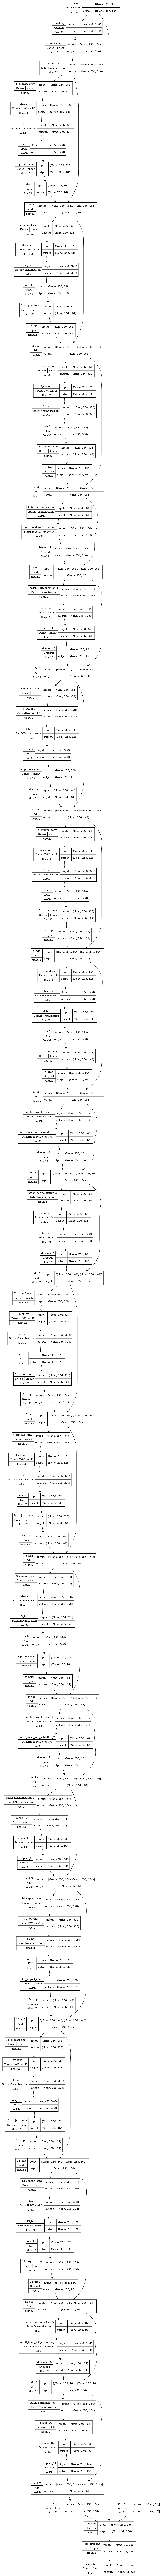

In [43]:
# Plot Model Architecture
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

# Verify Training Flag

In [44]:
def verify_correct_training_flag():
    # Verify static output for inference
    pred = model(X_batch_small, training=False)
    for _ in tqdm(range(10)):
        assert tf.reduce_min(tf.cast(pred == model(X_batch_small, training=False), tf.int8)) == 1

    # Verify at least 99% varying output due to dropout during training
    for _ in tqdm(range(10)):
        assert tf.reduce_mean(tf.cast(pred != model(X_batch_small, training=True), tf.float32)) > 0.99
        
verify_correct_training_flag()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

# Verify No NaN Predictions

In [45]:
# Verify No NaN predictions
def verify_no_nan_predictions():
    y_pred = model.predict(
        val_dataset if USE_VAL else train_dataset,
        steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else 100,
        verbose=VERBOSE,
    )

    print(f'# NaN Values In Predictions: {np.isnan(y_pred).sum()}')
    
    plt.figure(figsize=(15,8))
    plt.title(f'Logit Predictions Initialized Model')
    pd.Series(y_pred.flatten()).plot(kind='hist', bins=128)
    plt.xlabel('Logits')
    plt.grid()
    plt.show()
    
verify_no_nan_predictions()

 17/243 [=>............................] - ETA: 11:39

KeyboardInterrupt: 

# Learning Rate Scheduler

In [46]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

In [ ]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)

# Weight Decay Callback

In [47]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

# Evaluate Initialized Model

In [48]:
# Evaluate Initialized Model On Validation Data
y_pred = model.evaluate(
    val_dataset if USE_VAL else train_dataset,
    steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else TRAIN_STEPS_PER_EPOCH,
    verbose=VERBOSE,
)

  5/243 [..............................] - ETA: 11:36 - loss: 4.8073 - top1acc: 0.0040 - top5acc: 0.0283

KeyboardInterrupt: 

# Baseline

In [49]:
# baseline accuracy when only pad token is predicted
if USE_VAL:
    baseline_accuracy = np.mean(y_val == PAD_TOKEN)
else:
    baseline_accuracy = np.mean(y_train == PAD_TOKEN)
print(f'Baseline Accuracy: {baseline_accuracy:.4f}')

Baseline Accuracy: 0.4113


# Train

In [ ]:
gc.collect()

In [ ]:
if TRAIN_MODEL:
    # Clear all models in GPU
    tf.keras.backend.clear_session()

    # Get new fresh model
    model = get_model()

    # Sanity Check
    model.summary()

    # Actual Training
    history = model.fit(
            x=train_dataset,
            steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
            epochs=N_EPOCHS,
            # Only used for validation data since training data is a generator
            validation_data=val_dataset if USE_VAL else None,
            validation_steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else None,
            callbacks=[
                lr_callback,
                WeightDecayCallback(),
            ],
            verbose=VERBOSE,
        )

In [49]:
# Load Weights
if LOAD_WEIGHTS:
    model.load_weights('/kaggle/input/1dcnn-decoderacc085/model.h5')
    print(f'Successfully Loaded Pretrained Weights')

Successfully Loaded Pretrained Weights


In [106]:
# Save Model Weights
if TRAIN_MODEL:
    model.save_weights('model.h5')

In [107]:
# Verify Model is Loaded Correctly
model.evaluate(
    val_dataset if USE_VAL else train_dataset,
    steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else TRAIN_STEPS_PER_EPOCH,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
)

  8/114 [=>............................] - ETA: 55s - loss: 2.0351 - top1acc: 0.7895 - top5acc: 0.9279

KeyboardInterrupt: 

# Levenshtein Distance

In [41]:
# Output Predictions to string
def outputs2phrase(outputs):
    if outputs.ndim == 2:
        outputs = np.argmax(outputs, axis=1)
    
    return ''.join([ORD2CHAR.get(s, '') for s in outputs])

In [50]:
@tf.function(jit_compile=True)
def predict_phrase(frames):
    # Add Batch Dimension
    frames = tf.expand_dims(frames, axis=0)
    # Start Phrase
    phrase = tf.fill([1,MAX_PHRASE_LENGTH], PAD_TOKEN) # why not sos?

    for idx in tf.range(MAX_PHRASE_LENGTH):
        # Cast phrase to int8
        phrase = tf.cast(phrase, tf.int8)
        # Predict Next Token
        outputs = model({
            'frames': frames,
            'phrase': phrase,
        })

        # Add predicted token to input phrase
        phrase = tf.cast(phrase, tf.int32)
        phrase = tf.where(
            tf.range(MAX_PHRASE_LENGTH) < idx + 1,
            tf.argmax(outputs, axis=2, output_type=tf.int32),
            phrase,
        )

    # Squeeze outputs
    outputs = tf.squeeze(phrase, axis=0)
    outputs = tf.one_hot(outputs, N_UNIQUE_CHARACTERS)

    # Return a dictionary with the output tensor
    return outputs

    # Return a dictionary with the output tensor
    return outputs

# Levenstein Distance Train

In [51]:
# Compute Levenstein Distances
def get_ld_train():
    N = 100 if IS_INTERACTIVE else 1000
    LD_TRAIN = []
    for idx, (frames, phrase_true) in enumerate(zip(tqdm(X_train, total=N), y_train)):
        # Predict Phrase and Convert to String
        phrase_pred = predict_phrase(frames).numpy()
        phrase_pred = outputs2phrase(phrase_pred)
        # True Phrase Ordinal to String
        phrase_true = outputs2phrase(phrase_true)
        # Add Levenstein Distance
        LD_TRAIN.append({
            'phrase_true': phrase_true,
            'phrase_true_len': len(phrase_true),
            'phrase_pred': phrase_pred,
            'levenshtein_distance': levenshtein(phrase_pred, phrase_true),
        })
        # Take subset in interactive mode
        if idx == N:
            break
            
    # Convert to DataFrame
    LD_TRAIN_DF = pd.DataFrame(LD_TRAIN)
    
    return LD_TRAIN_DF

In [52]:
LD_TRAIN_DF = get_ld_train()

# Display Errors
display(LD_TRAIN_DF.head(30))

  0%|          | 0/100 [00:00<?, ?it/s]

,phrase_true,phrase_true_len,phrase_pred,levenshtein_distance
0,3 creekhouse,12,3 creekhouse se300,6
1,hentaihubs.com,14,hentaihubs.com.com,4
2,1383 william lanier,19,1383 william lanier,0
3,988 franklin lane,17,988 franklin lane,0
4,6920 northeast 661st road,25,6920 northeast 661st road,0
5,www.freem.ne.jp,15,www.freem.ne.jp.jp,3
6,https://jsi.is/hukuoka,22,https://jsi.is/hkuokuokaa,3
7,239613 stolze street,20,239613 stolze street,0
8,242-197-6202,12,+227-74-62-74-02-74o,14
9,271097 bayshore boulevard,25,271097 bayhore boulevard,1


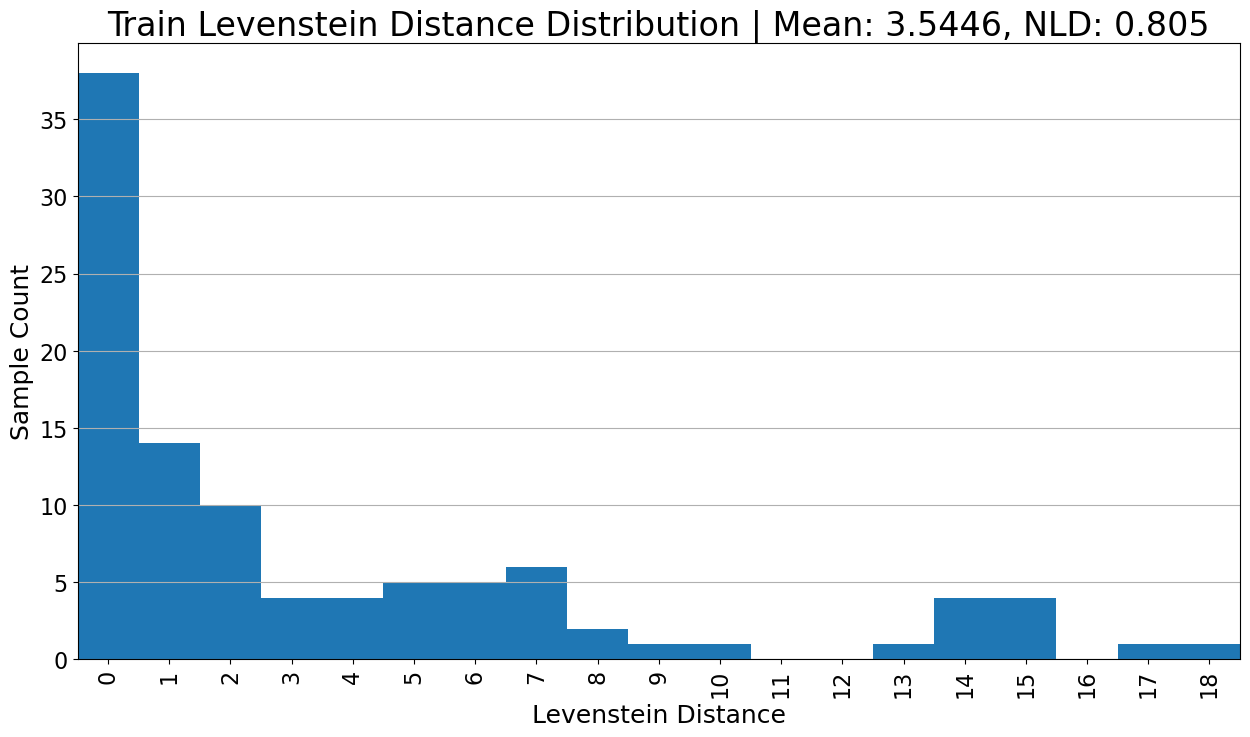

In [53]:
# Value Counts
LD_TRAIN_VC = dict([(i, 0) for i in range(LD_TRAIN_DF['levenshtein_distance'].max()+1)])
for ld in LD_TRAIN_DF['levenshtein_distance']:
    LD_TRAIN_VC[ld] += 1

# Evaluation Metric
N = LD_TRAIN_DF['phrase_true_len'].sum()
D = LD_TRAIN_DF['levenshtein_distance'].sum()
nld = (N - D) / N

LD_TRAIN_VC = dict([(i, 0) for i in range(LD_TRAIN_DF['levenshtein_distance'].max()+1)])
for ld in LD_TRAIN_DF['levenshtein_distance']:
    LD_TRAIN_VC[ld] += 1

plt.figure(figsize=(15,8))
pd.Series(LD_TRAIN_VC).plot(kind='bar', width=1)
plt.title(f'Train Levenstein Distance Distribution | Mean: {LD_TRAIN_DF.levenshtein_distance.mean():.4f}, NLD: {nld:.3f}')
plt.xlabel('Levenstein Distance')
plt.ylabel('Sample Count')
plt.xlim(-0.50, LD_TRAIN_DF.levenshtein_distance.max()+0.50)
plt.grid(axis='y')
plt.savefig('temp.png')
plt.show()

# Levenstein Distance Evaluation

In [54]:
# Compute Levenstein Distances
def get_ld_val():
    N = 100 if IS_INTERACTIVE else 1000
    LD_VAL = []
    for idx, (frames, phrase_true) in enumerate(zip(tqdm(X_val, total=N), y_val)):
        # Predict Phrase and Convert to String
        phrase_pred = predict_phrase(frames).numpy()
        phrase_pred = outputs2phrase(phrase_pred)
        # True Phrase Ordinal to String
        phrase_true = outputs2phrase(phrase_true)
        # Add Levenstein Distance
        LD_VAL.append({
            'phrase_true': phrase_true,
            'phrase_true_len': len(phrase_true),
            'phrase_pred': phrase_pred,
            'levenshtein_distance': levenshtein(phrase_pred, phrase_true),
        })
        # Take subset in interactive mode
        if idx == N:
            break
            
    # Convert to DataFrame
    LD_VAL_DF = pd.DataFrame(LD_VAL)
    
    return LD_VAL_DF

In [55]:
if USE_VAL:
    LD_VAL_DF = get_ld_val()

    # Display Errors
    display(LD_VAL_DF.head(30))

  0%|          | 0/100 [00:00<?, ?it/s]

,phrase_true,phrase_true_len,phrase_pred,levenshtein_distance
0,scales/kuhaylah,15,sales puhayla,4
1,+51-2721-208-63,15,+51-7121-208-63,2
2,1600 fire water,15,1600 jiwaterch,6
3,620-510-6135,12,620-510-6134,1
4,69 alec roy south road,22,2608 south court oad,15
5,6738 co 5670,12,738-567-5670,6
6,201 galveston country club dr,29,201 glveston country drive,8
7,4821 holly ridge circle,23,4821 holly ridge circlee,1
8,www.ipsah.edu.my,16,www.ipshedu.myy,3
9,1088 west aberdeen street,25,88 west aberdeen street,2


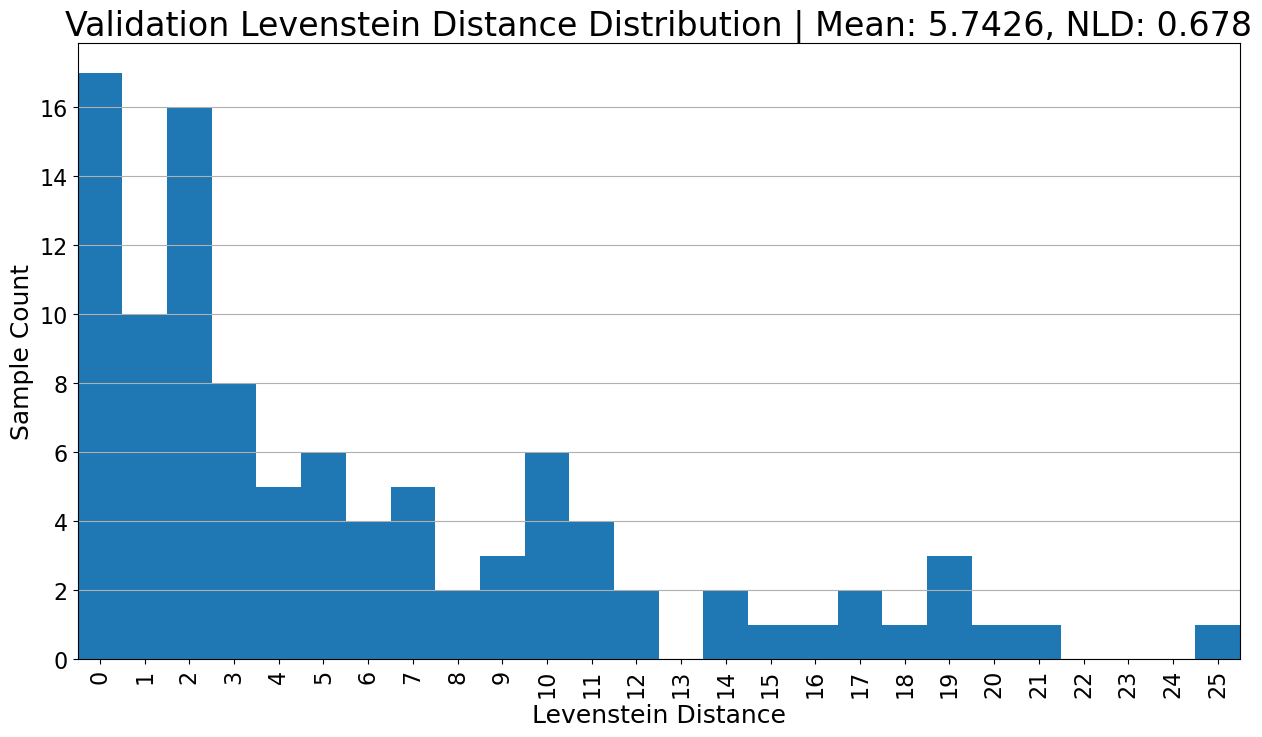

In [56]:
# Value Counts
if USE_VAL:
    # Evaluation Metric
    N = LD_VAL_DF['phrase_true_len'].sum()
    D = LD_VAL_DF['levenshtein_distance'].sum()
    nld = (N - D) / N
    
    LD_VAL_VC = dict([(i, 0) for i in range(LD_VAL_DF['levenshtein_distance'].max()+1)])
    for ld in LD_VAL_DF['levenshtein_distance']:
        LD_VAL_VC[ld] += 1

    plt.figure(figsize=(15,8))
    pd.Series(LD_VAL_VC).plot(kind='bar', width=1)
    plt.title(f'Validation Levenstein Distance Distribution | Mean: {LD_VAL_DF.levenshtein_distance.mean():.4f}, NLD: {nld:.3f}')
    plt.xlabel('Levenstein Distance')
    plt.ylabel('Sample Count')
    plt.xlim(-0.50, LD_VAL_DF.levenshtein_distance.max()+0.50)
    plt.grid(axis='y')
    plt.savefig('temp.png')
    plt.show()

# Training History

In [116]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    # Only plot when training
    if not TRAIN_MODEL:
        return
    
    plt.figure(figsize=(20, 10))
    
    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

In [117]:
plot_history_metric('loss', f_best=np.argmin)

In [118]:
plot_history_metric('top1acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

In [119]:
plot_history_metric('top5acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

# Inference

In [80]:
enc_out = tf.keras.Model(model.input, model.get_layer("top_conv").output)

In [88]:
# TFLite model for submission
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.model = model
        self.encoder = tf.keras.Model(model.input, model.get_layer("top_conv").output)
    
#     @tf.function(jit_compile=True)
#     def encoder(self, x, frames_inp):
#         for l in encoder_layers:
#             x = self.model.get_layer(l)(x)
        
#         return x
        
    @tf.function(jit_compile=True)
    def decoder(self, x, phrase_inp, frames_inp):
        x = self.model.get_layer('decoder')(x, phrase_inp, frames_inp)
        x = self.model.get_layer('late_dropout')(x)
        x = self.model.get_layer('classifier')(x)
        
        return x
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, N_COLS0], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        # Number Of Input Frames
        N_INPUT_FRAMES = tf.shape(inputs)[0]
        # Preprocess Data
        frames_inp = self.preprocess_layer(inputs)        
        # Add Batch Dimension
        frames_inp = tf.expand_dims(frames_inp, axis=0)
        
        # Make Prediction
        phrase = tf.fill([1,MAX_PHRASE_LENGTH], PAD_TOKEN)
        
        # Get Encoding
        encoding = self.encoder(inputs=[frames_inp, phrase])
        
        stop = False
        for idx in tf.range(MAX_PHRASE_LENGTH):
            # Cast phrase to int8
            phrase = tf.cast(phrase, tf.int8)
            # If EOS token is predicted, stop predicting
            outputs = tf.cond(
                stop,
                lambda: tf.one_hot(tf.cast(phrase, tf.int32), N_UNIQUE_CHARACTERS),
                lambda: self.decoder(encoding, phrase, frames_inp)
            )
            # Add predicted token to input phrase
            phrase = tf.cast(phrase, tf.int32)
            # Replcae PAD token with predicted token up to idx
            phrase = tf.where(
                tf.range(MAX_PHRASE_LENGTH) < idx + 1,
                tf.argmax(outputs, axis=2, output_type=tf.int32),
                phrase,
            )
            # Predicted Token
            predicted_token = phrase[0,idx]
            # If EOS (End Of Sentence) token is predicted stop
            if not stop:
                stop = predicted_token == EOS_TOKEN
            
        # Squeeze outputs
        outputs = tf.squeeze(phrase, axis=0)
        outputs = tf.one_hot(outputs, N_UNIQUE_CHARACTERS)
            
        # Return a dictionary with the output tensor
        return {'outputs': outputs }

# Define TF Lite Model
tflite_keras_model = TFLiteModel(model)

# Sanity Check
# demo_sequence_id = 1816796431
demo_sequence_id = example_parquet_df.index.unique()[0]
demo_raw_data = example_parquet_df.loc[demo_sequence_id, COLUMNS0].values
demo_phrase_true = train_sequence_id.loc[demo_sequence_id, 'phrase']
print(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
demo_output = tflite_keras_model(demo_raw_data)['outputs'].numpy()
print(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
print(f'demo_outputs phrase decoded: {outputs2phrase(demo_output)}')
print(f'phrase true: {demo_phrase_true}')

demo_raw_data shape: (123, 164), dtype: float32
demo_output shape: (32, 62), dtype: float32
demo_outputs phrase decoded: 3 creekhouse
phrase true: 3 creekhouse


In [89]:
# Create Model Converter
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
# Convert Model
tflite_model = keras_model_converter.convert()
# Write Model
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [90]:
# Add selected_columns json to only select specific columns from input frames
with open('inference_args.json', 'w') as f:
     json.dump({ 'selected_columns': COLUMNS0.tolist() }, f)

In [ ]:
# Zip Model
!zip submission.zip /kaggle/working/model.tflite /kaggle/working/inference_args.json